In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
recent = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(f'''Most recent date in dataset: {recent.date}''')

Most recent date in dataset: 2017-08-23


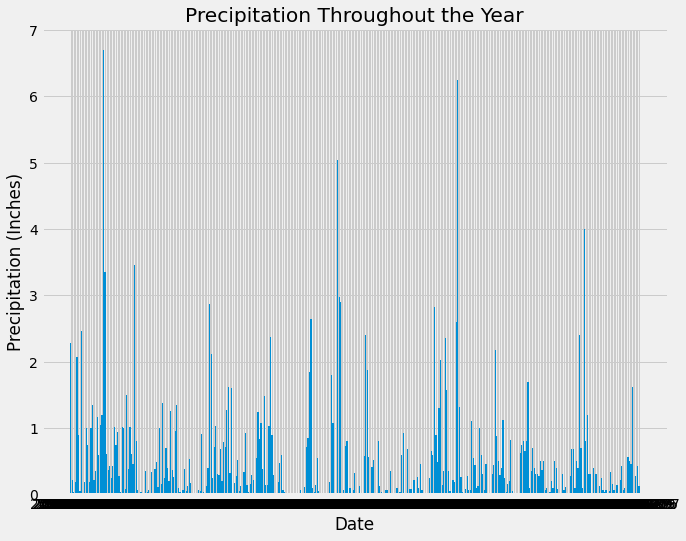

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = dt.datetime.strptime(recent.date, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
query_date = last_date - dt.timedelta(days=364)

# Perform a query to retrieve the data and precipitation scores
recent_measure = session.query(Measurement.date, Measurement.prcp).filter(func.strftime('%Y-%m-%d', Measurement.date) >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
recent_measure_df = pd.DataFrame(recent_measure, columns=['Date','Precipitation'])

# Sort the dataframe by date
sorted_measure_df = recent_measure_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(12,8));
ax.bar(sorted_measure_df['Date'], sorted_measure_df['Precipitation']);
ax.set(xlabel ='Date', ylabel = 'Precipitation (Inches)', title = 'Precipitation Throughout the Year');

In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_measure_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()

[(9)]

In [30]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
act_station_list = [Measurement.station, func.count(Measurement.station)]

act_station = session.query(*act_station_list).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first().station

session.query(*act_station_list).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

query = session.query(*temp).group_by(Measurement.station).filter(Measurement.station == act_station).all()

print(f'''Most active station id: {query[0][0]}
Lowest Temp: {query[0][1]}
Highest Temp: {query[0][2]}
Avg Temp: {query[0][3]}''')

Most active station id: USC00519281
Lowest Temp: 54.0
Highest Temp: 85.0
Avg Temp: 71.66378066378067


In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
act_station_temp = session.query(Measurement.station, Measurement.tobs).filter(func.strftime('%Y-%m-%d', Measurement.date) > query_date).filter(Measurement.station == act_station).all()
act_station_temp_df = pd.DataFrame(act_station_temp, columns = ['Station', 'Temperature'])

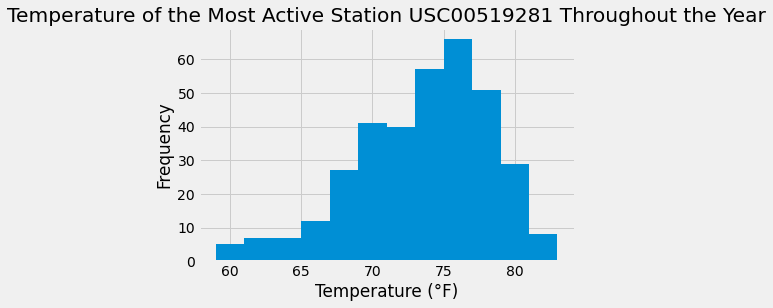

In [37]:
fig2, ax2 = plt.subplots();
ax2.hist(act_station_temp_df['Temperature'], bins=12);
ax2.set(xlabel ='Temperature (°F)', ylabel = 'Frequency', title = f'Temperature of the Most Active Station {act_station_temp[0][0]} Throughout the Year');

# Close session

In [36]:
# Close Session
session.close()